In [1]:
import torch
import torchvision
import tarfile
import matplotlib.pyplot as plt
import numpy as np
import os
from torchvision.datasets import MNIST
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Normalize
from torch.utils.data.dataloader import DataLoader

In [30]:
mnist = MNIST(root = './', 
                train = True,
                transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
                )

In [32]:
img, label = mnist[5]
# print(img)
print(label)

2


In [33]:
def denorm(x):
    out = (x+1) / 2
    return out.clamp(0 , 1)

Label: 2


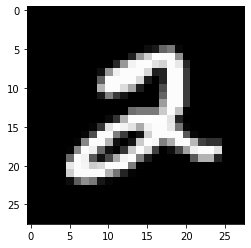

In [34]:
%matplotlib inline
denorm(img)
plt.imshow(img[0], cmap = 'gray')
print('Label:', label)

In [35]:
data_batch = DataLoader(dataset = data,
                            batch_size = 100,
                            shuffle = True)

torch.Size([100, 1, 28, 28])
tensor([8, 1, 7, 7, 2, 9, 8, 5, 8, 5, 2, 2, 6, 9, 5, 4, 4, 3, 7, 0, 2, 8, 4, 1,
        1, 8, 2, 5, 9, 5, 2, 2, 1, 7, 3, 6, 0, 7, 8, 1, 6, 5, 7, 3, 6, 6, 6, 3,
        8, 0, 9, 4, 8, 6, 3, 5, 2, 9, 5, 6, 7, 1, 0, 1, 0, 1, 1, 4, 1, 3, 2, 6,
        1, 4, 9, 2, 0, 5, 8, 3, 9, 5, 4, 3, 8, 5, 3, 2, 6, 1, 9, 6, 2, 4, 7, 5,
        3, 0, 0, 5])


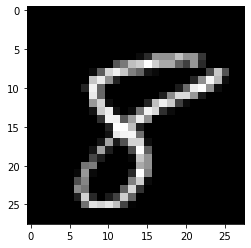

In [41]:
for img, label in data_batch:
    print(img.shape)
    # print(img[0][0])
    plt.imshow(img[0][0], cmap = 'gray')
    print(label)
    break